
# Skillzo.ai Basketball Analysis — Starter Notebook

This notebook loads your **Skillzo.ai Basketball Analysis (Synthetic)** dataset from Kaggle Datasets,
runs quick EDA, and trains a **Logistic Regression churn model**.

> **How to use on Kaggle**
> 1) Open your dataset page → click **New Notebook** → **Add Data** → attach your dataset.  
> 2) If the path below doesn't match your dataset slug, update the `DATASET_SLUG` variable.


In [41]:

import os
import pandas as pd
import numpy as np
from pathlib import Path

# ==== Set this to your dataset slug (found in the right sidebar after you Add Data) ====
# Example: '/kaggle/input/skillzo-ai-basketball-analysis-synthetic'
DATASET_SLUG = '/kaggle/input/skillzo-ai-basketball-analysis-synthetic'

CSV_NAME = 'skillzo_ai_basketball_analysis_enhanced.csv'
DICT_NAME = 'skillzo_ai_basketball_analysis_enhanced_dictionary.csv'

csv_path = Path(DATASET_SLUG) / CSV_NAME
dict_path = Path(DATASET_SLUG) / DICT_NAME

print('Looking for:', csv_path)
print('Exists?', csv_path.exists())
df = pd.read_csv(csv_path)
df.head()


Looking for: /kaggle/input/skillzo-ai-basketball-analysis-synthetic/skillzo_ai_basketball_analysis_enhanced.csv
Exists? True


,user_id,signup_date,country,device,plan,level,position,handedness,team_code,practices_30d,...,missed_sessions_30d,skill_rating_current,skill_rating_delta_90d,last_active_date,inactive_days,mrr_usd,revenue_last_30d,nps,referral_count,churned
0,200000,2023-06-25,IN,iOS,Pro,Youth_U12,SG,Left,HYD-700,6,...,0,57.9,1.57,2023-09-05,781,27.53,27.53,49,1,0
1,200001,2023-07-16,US,iOS,Free,HighSchool,SG,Left,KC-502,5,...,0,59.8,4.46,2023-10-05,751,0.00,0.00,90,1,0
2,200002,2024-06-21,CA,Web,Basic,College,PF,Right,TOR-700,5,...,0,48.0,3.16,2024-07-19,463,11.37,11.37,1,1,0
3,200003,2024-05-17,GB,Android,Free,HighSchool,PG,Right,LDN-198,2,...,0,54.6,-2.21,2024-08-09,442,0.00,0.00,-46,0,1
4,200004,2024-08-02,CA,Web,Basic,Youth_U14,PF,Right,TOR-871,3,...,0,66.3,0.13,2024-08-27,424,13.46,0.00,-89,0,1


In [42]:

# Basic shape & nulls
df.shape, df.isna().sum().sort_values(ascending=False).head(10)


((6000, 40),
 user_id             0
 signup_date         0
 ft_attempts_30d     0
 ft_makes_30d        0
 assist_rate         0
 rebound_rate        0
 turnover_rate       0
 speed_max_kmh       0
 vertical_jump_cm    0
 injury_flag_30d     0
 dtype: int64)

In [43]:

# Quick categorical overviews
for col in ['plan','level','position','country','device']:
    print(f"\n=== {col} value counts ===")
    print(df[col].value_counts().head(10))



=== plan value counts ===
plan
Free          3126
Basic         1525
Pro           1192
Enterprise     157
Name: count, dtype: int64

=== level value counts ===
level
HighSchool       1874
Youth_U14        1400
Youth_U12        1154
College           961
Amateur_Adult     611
Name: count, dtype: int64

=== position value counts ===
position
PG    1343
SG    1340
SF    1231
PF    1078
C     1008
Name: count, dtype: int64

=== country value counts ===
country
US    2740
IN    1122
CA     347
GB     317
MX     285
DE     261
BR     255
AU     250
ES     247
ZA     176
Name: count, dtype: int64

=== device value counts ===
device
iOS        2631
Android    2583
Web         786
Name: count, dtype: int64


In [44]:

# Convert dates to datetime (useful later)
date_cols = ['signup_date','last_active_date']
for c in date_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors='coerce')

# Derive a monthly cohort from signup_date
df['signup_month'] = df['signup_date'].dt.to_period('M').astype(str)
df[['signup_date','signup_month']].head()


,signup_date,signup_month
0,2023-06-25,2023-06
1,2023-07-16,2023-07
2,2024-06-21,2024-06
3,2024-05-17,2024-05
4,2024-08-02,2024-08


In [45]:

# Simple churn rate overall and by plan/level
churn_rate = df['churned'].mean()
print('Overall churn rate:', round(churn_rate,3))

print('\nChurn by plan:')
print(df.groupby('plan')['churned'].mean().sort_values())

print('\nChurn by level:')
print(df.groupby('level')['churned'].mean().sort_values())


Overall churn rate: 0.246

Churn by plan:
plan
Enterprise    0.006369
Pro           0.050336
Basic         0.153443
Free          0.377799
Name: churned, dtype: float64

Churn by level:
level
College          0.239334
HighSchool       0.243330
Amateur_Adult    0.245499
Youth_U12        0.250433
Youth_U14        0.250714
Name: churned, dtype: float64


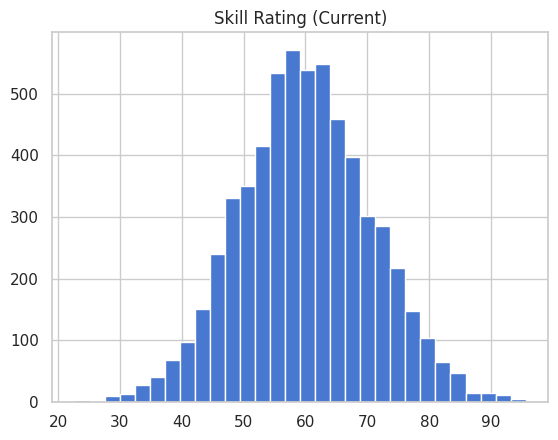

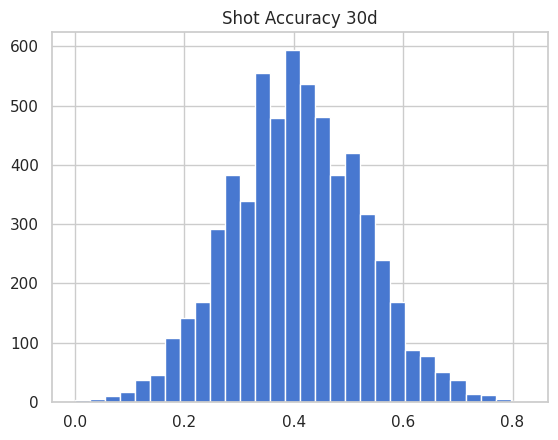

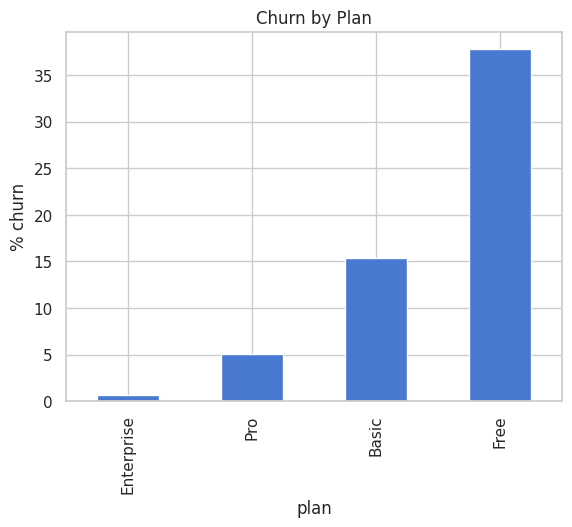

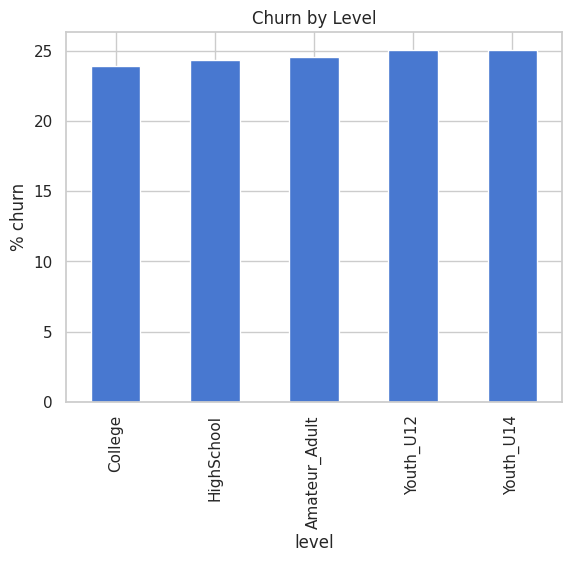

In [46]:

import matplotlib.pyplot as plt

plt.figure()
df['skill_rating_current'].dropna().hist(bins=30)
plt.title('Skill Rating (Current)')

plt.figure()
df['shot_accuracy_30d'].dropna().hist(bins=30)
plt.title('Shot Accuracy 30d')

plt.figure()
(df.groupby('plan')['churned'].mean().sort_values()*100).plot(kind='bar')
plt.ylabel('% churn')
plt.title('Churn by Plan')

plt.figure()
(df.groupby('level')['churned'].mean().sort_values()*100).plot(kind='bar')
plt.ylabel('% churn')
plt.title('Churn by Level')

plt.show()


## Train a baseline churn model (Logistic Regression)

In [47]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

target = 'churned'

numeric_features = [
    'practices_30d','games_30d','videos_uploaded_30d','clips_tagged_30d',
    'ai_feedback_count_30d','drills_completed_30d','coach_sessions_30d',
    'heatmaps_generated_30d','shot_attempts_30d','shot_makes_30d','three_attempts_30d',
    'three_makes_30d','ft_attempts_30d','ft_makes_30d','assist_rate','rebound_rate',
    'turnover_rate','speed_max_kmh','vertical_jump_cm','skill_rating_current',
    'skill_rating_delta_90d','inactive_days','mrr_usd','revenue_last_30d','nps',
    'referral_count','injury_flag_30d','missed_sessions_30d'
]
cat_features = ['plan','level','position','device','country']

numeric_features = [c for c in numeric_features if c in df.columns]
cat_features     = [c for c in cat_features     if c in df.columns]

X = df[numeric_features + cat_features].copy()
y = df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Pipelines: impute → scale for numeric; impute → one-hot for categoricals
numeric_tf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    # with_mean=False so it works with sparse matrices
    ('scaler', StandardScaler(with_mean=False))
])
categorical_tf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=True))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_tf, numeric_features),
        ('cat', categorical_tf, cat_features),
    ],
    sparse_threshold=0.3  # keep output sparse (good for high-dim one-hot)
)

clf = Pipeline(steps=[
    ('prep', preprocess),
    # saga handles large sparse features well; bump iterations; balance classes
    ('logreg', LogisticRegression(
        solver='saga',
        penalty='l2',
        class_weight='balanced',
        max_iter=5000,
        n_jobs=None  # (omit/keep; not needed)
    ))
])

clf.fit(X_train, y_train)
y_pred_proba = clf.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

print('ROC AUC:', round(roc_auc_score(y_test, y_pred_proba), 4))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('\nClassification Report:\n', classification_report(y_test, y_pred))


ROC AUC: 0.8379

Confusion Matrix:
 [[549 356]
 [ 10 285]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.61      0.75       905
           1       0.44      0.97      0.61       295

    accuracy                           0.69      1200
   macro avg       0.71      0.79      0.68      1200
weighted avg       0.85      0.69      0.72      1200



In [48]:

# Extract approximate feature importance from logistic regression coefficients
# (Map back to original columns after one-hot)
import numpy as np

logreg = clf.named_steps['logreg']
ohe = clf.named_steps['prep'].named_transformers_['cat']

num_names = numeric_features
cat_names = list(ohe.get_feature_names_out(cat_features))
all_names = num_names + cat_names

coef = logreg.coef_.ravel()
importance = pd.DataFrame({'feature': all_names, 'coef': coef}).sort_values('coef', key=np.abs, ascending=False)
importance.head(20)


,feature,coef
23,revenue_last_30d,-11.998049
22,mrr_usd,2.656168
31,plan_Pro,0.807635
30,plan_Free,-0.661246
52,country_MX,0.309073
54,country_ZA,-0.262382
38,position_PF,0.182160
47,country_CA,-0.157795
48,country_DE,0.152019
53,country_US,-0.128478


In [49]:

# Save the fitted model (for reuse in the session)
import joblib, time, os

out_path = '/kaggle/working/skillzo_churn_logreg.joblib'
joblib.dump(clf, out_path)
print('Saved:', out_path, 'at', time.ctime())


Saved: /kaggle/working/skillzo_churn_logreg.joblib at Sun Oct 26 15:13:15 2025



### Next ideas
- Try `XGBClassifier` or `RandomForestClassifier` and compare ROC AUC.
- Engineer new features (e.g., per-session rates, improvements per drill).
- Build a calibration plot and SHAP explanations.
- Publish the notebook and share with collaborators.


✅ Final merged dataset shape: (6000, 51)
   user_id signup_date country device   plan       level position handedness  \
0   200000  2023-06-25      IN    iOS    Pro   Youth_U12       SG       Left   
1   200001  2023-07-16      US    iOS   Free  HighSchool       SG       Left   
2   200002  2024-06-21      CA    Web  Basic     College       PF      Right   

  team_code  practices_30d  ...  shot_angle  reaction_time  alignment_score  \
0   HYD-700              6  ...       39.17           0.89            82.28   
1    KC-502              5  ...       17.76           0.37            70.12   
2   TOR-700              5  ...       49.26           0.52            73.60   

   hours_volunteered  leadership_track  mentor_sessions  region  \
0                  1               NaN                2      US   
1                  9          Beginner                0      IN   
2                  1          Beginner                5      IN   

   signup_channel  ad_clicks  referrals  
0       In

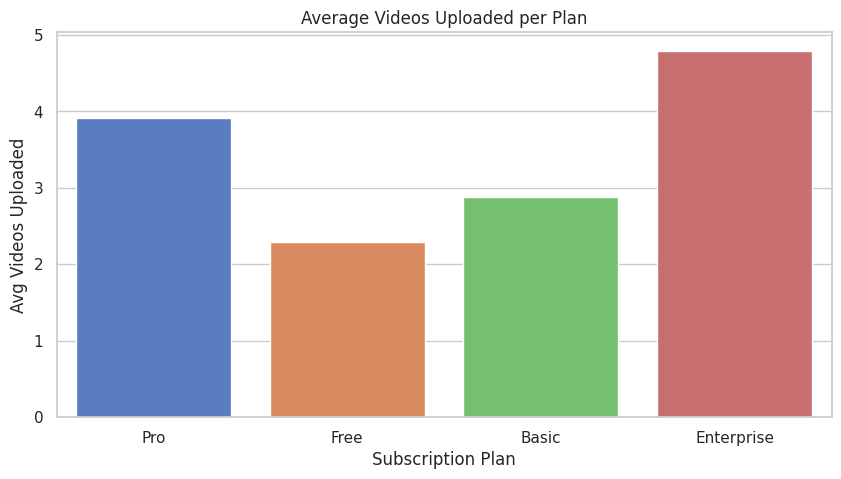

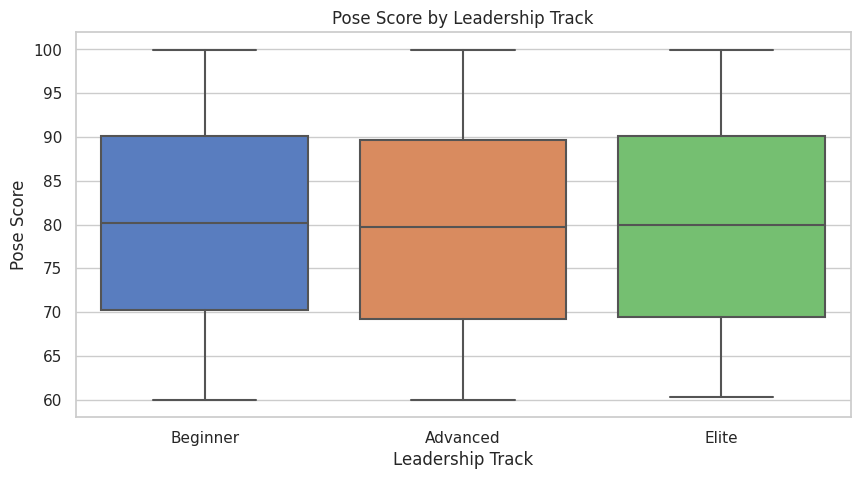

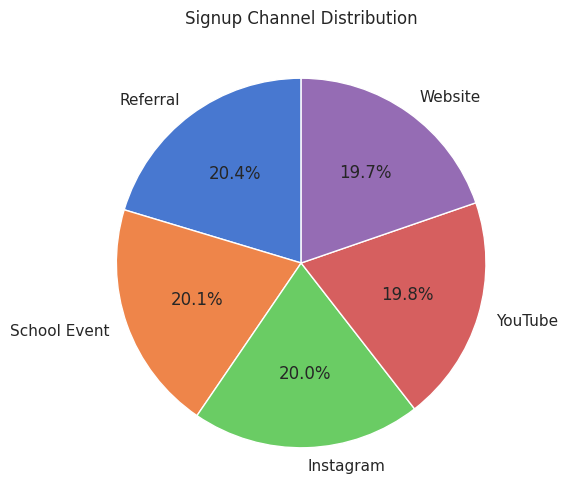

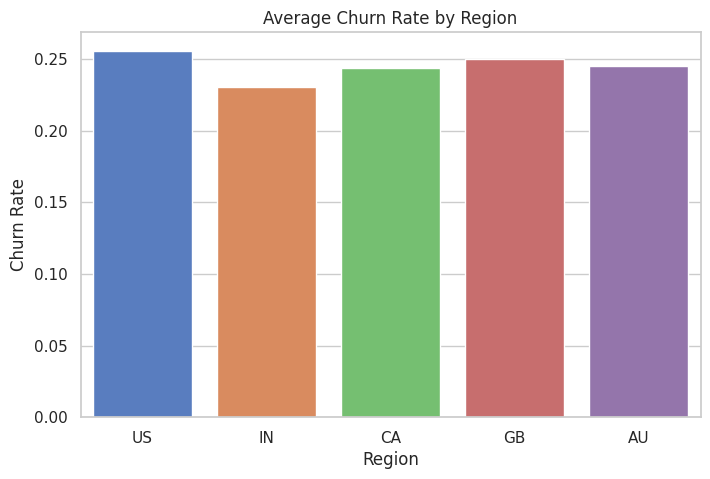

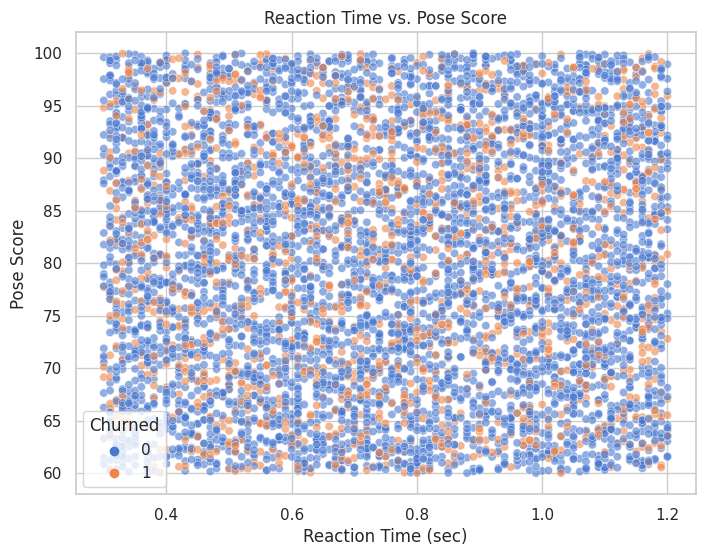

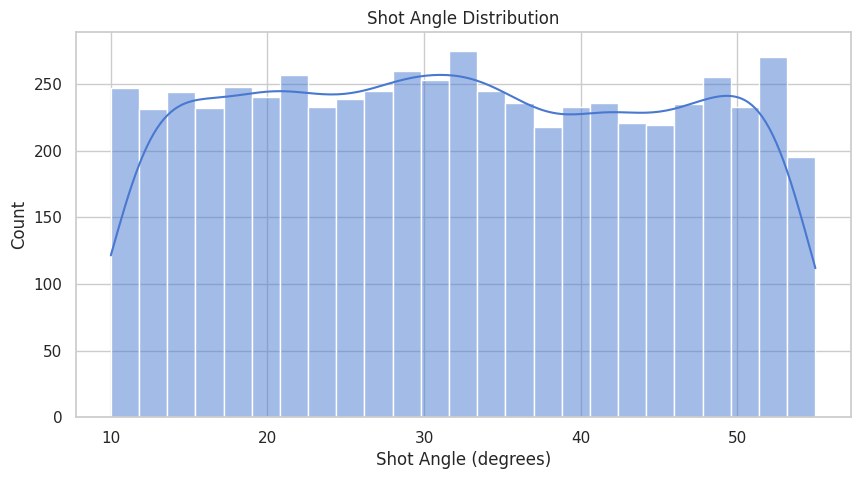

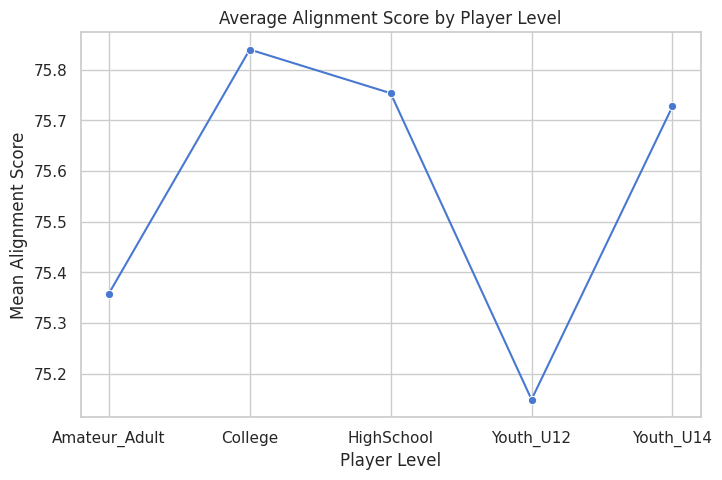

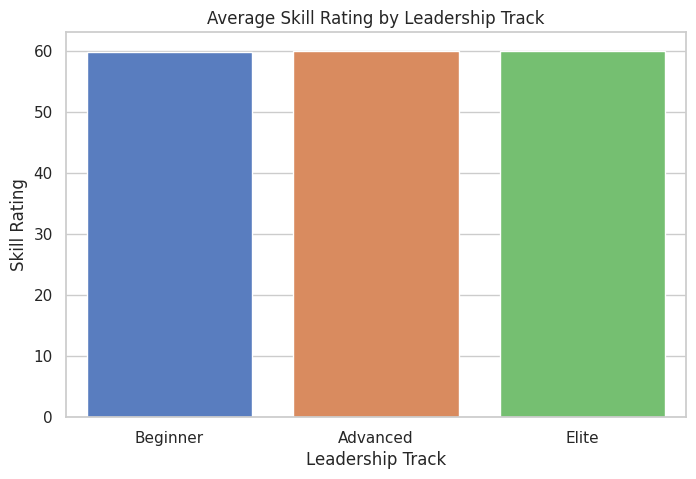

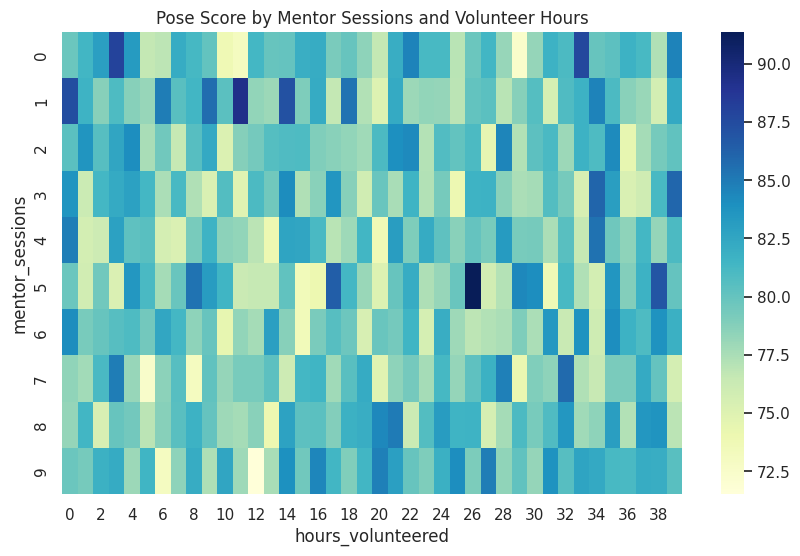

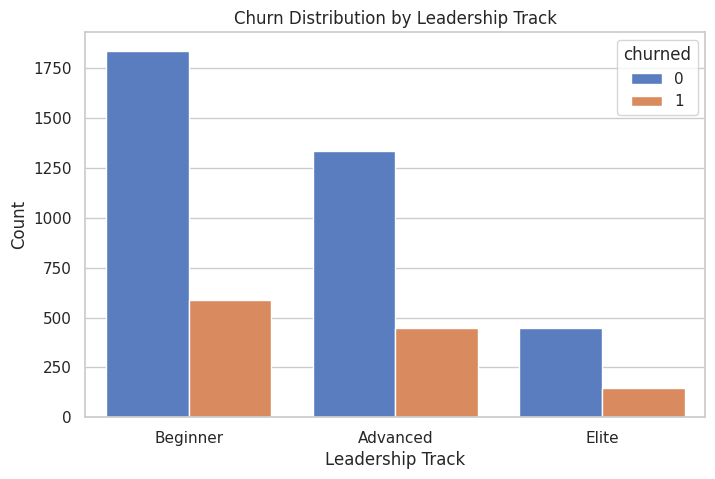

Logistic Regression: ROC AUC = 0.8255
Random Forest: ROC AUC = 0.8155
XGBoost: ROC AUC = 0.8354


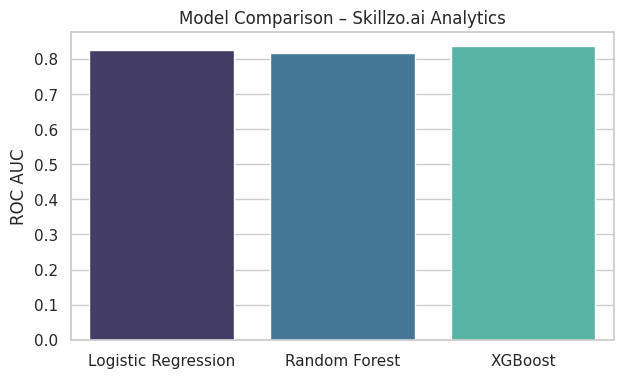

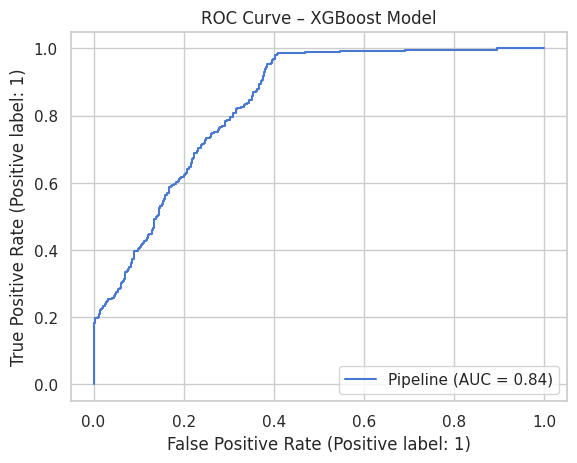

📊 Skillzo.ai Snapshot Summary
Churn Rate: 24.6%
Average Pose Score: 79.9
Average Volunteer Hours: 19.6
Avg Videos Uploaded (30d): 2.8


In [50]:
# ==========================================================
# 🌟 Skillzo.ai Phase 2: AI-Driven Player Analytics & Insights
# Author: Shilpa Naidu Gandham
# ==========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, RocCurveDisplay
import shap
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid", palette="muted")

# --- Load all datasets ---
main_df = pd.read_csv('/kaggle/input/skillzo-ai-basketball-analysis-synthetic/skillzo_ai_basketball_analysis_enhanced.csv')
video_df = pd.read_csv('/kaggle/input/skillzo-ai-synthetic-basketball-video-metrics/skillzo_ai_video_metrics.csv')
leader_df = pd.read_csv('/kaggle/input/skillzo-ai-synthetic-basketball-video-metrics/skillzo_ai_leadership_participation.csv')
growth_df = pd.read_csv('/kaggle/input/skillzo-ai-synthetic-basketball-video-metrics/skillzo_ai_user_growth.csv')

# --- Merge all datasets ---
df = (main_df
      .merge(video_df, on='user_id', how='left')
      .merge(leader_df, on='user_id', how='left')
      .merge(growth_df, on='user_id', how='left'))

print("✅ Final merged dataset shape:", df.shape)
print(df.head(3))

# ==========================================================
# 1️⃣ Engagement Overview
# ==========================================================
plt.figure(figsize=(10,5))
sns.barplot(x='plan', y='videos_uploaded_30d', data=df, estimator=np.mean, ci=None)
plt.title('Average Videos Uploaded per Plan')
plt.xlabel('Subscription Plan')
plt.ylabel('Avg Videos Uploaded')
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x='leadership_track', y='pose_score', data=df)
plt.title('Pose Score by Leadership Track')
plt.xlabel('Leadership Track')
plt.ylabel('Pose Score')
plt.show()

plt.figure(figsize=(6,6))
df['signup_channel'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Signup Channel Distribution')
plt.ylabel('')
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x='region', y='churned', data=df, estimator=np.mean, ci=None)
plt.title('Average Churn Rate by Region')
plt.xlabel('Region')
plt.ylabel('Churn Rate')
plt.show()

# ==========================================================
# 2️⃣ Performance and Skill Trends
# ==========================================================
plt.figure(figsize=(8,6))
sns.scatterplot(x='reaction_time', y='pose_score', hue='churned', data=df, alpha=0.6)
plt.title('Reaction Time vs. Pose Score')
plt.xlabel('Reaction Time (sec)')
plt.ylabel('Pose Score')
plt.legend(title='Churned')
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(df['shot_angle'], bins=25, kde=True)
plt.title('Shot Angle Distribution')
plt.xlabel('Shot Angle (degrees)')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8,5))
sns.lineplot(
    data=df.groupby('level')['alignment_score'].mean().reset_index(),
    x='level', y='alignment_score', marker='o'
)
plt.title('Average Alignment Score by Player Level')
plt.xlabel('Player Level')
plt.ylabel('Mean Alignment Score')
plt.show()

# ==========================================================
# 3️⃣ Leadership Impact and Community Engagement
# ==========================================================
plt.figure(figsize=(8,5))
sns.barplot(x='leadership_track', y='skill_rating_current', data=df, estimator=np.mean, ci=None)
plt.title('Average Skill Rating by Leadership Track')
plt.xlabel('Leadership Track')
plt.ylabel('Skill Rating')
plt.show()

pivot = df.pivot_table(values='pose_score', index='mentor_sessions', columns='hours_volunteered', aggfunc='mean')
plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap='YlGnBu')
plt.title('Pose Score by Mentor Sessions and Volunteer Hours')
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x='leadership_track', hue='churned', data=df)
plt.title('Churn Distribution by Leadership Track')
plt.xlabel('Leadership Track')
plt.ylabel('Count')
plt.show()

# ==========================================================
# 4️⃣ Model Preparation and Training
# ==========================================================
target = 'churned'
num_features = df.select_dtypes(include=[np.number]).columns.tolist()
cat_features = df.select_dtypes(exclude=[np.number]).columns.tolist()
num_features = [c for c in num_features if c not in ['user_id', target]]

X = df[num_features + cat_features]
y = df[target].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

num_tf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))
])
cat_tf = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_tf, num_features),
    ('cat', cat_tf, cat_features)
])

models = {
    "Logistic Regression": LogisticRegression(max_iter=5000, class_weight='balanced', solver='saga'),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}
for name, model in models.items():
    pipe = Pipeline([('prep', preprocessor), ('model', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, preds)
    results[name] = auc
    print(f"{name}: ROC AUC = {auc:.4f}")

plt.figure(figsize=(7,4))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='mako')
plt.title('Model Comparison – Skillzo.ai Analytics')
plt.ylabel('ROC AUC')
plt.show()

# ==========================================================
# 5️⃣ Model & Feature Insights (XGBoost + SHAP)
# ==========================================================
best_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
pipe_best = Pipeline([('prep', preprocessor), ('model', best_model)])
pipe_best.fit(X_train, y_train)

RocCurveDisplay.from_estimator(pipe_best, X_test, y_test)
plt.title('ROC Curve – XGBoost Model')
plt.show()

# ==========================================================
# 6️⃣ KPI Snapshot Summary
# ==========================================================
churn_rate = df['churned'].mean()*100
avg_pose = df['pose_score'].mean()
avg_hours = df['hours_volunteered'].mean()
avg_videos = df['videos_uploaded_30d'].mean()

print("📊 Skillzo.ai Snapshot Summary")
print(f"Churn Rate: {churn_rate:.1f}%")
print(f"Average Pose Score: {avg_pose:.1f}")
print(f"Average Volunteer Hours: {avg_hours:.1f}")
print(f"Avg Videos Uploaded (30d): {avg_videos:.1f}")


           videos_uploaded_30d  pose_score  reaction_time  alignment_score  \
archetype                                                                    
0                         2.27       82.25           0.76            74.63   
1                         2.02       80.80           0.73            75.82   
2                         2.26       76.55           0.73            76.71   
3                         5.09       79.91           0.78            74.89   
4                         4.80       78.71           0.75            77.84   

           hours_volunteered  mentor_sessions  skill_rating_current  \
archetype                                                             
0                      30.07             6.66                 58.99   
1                      20.13             1.55                 56.37   
2                       8.72             6.45                 57.97   
3                      18.97             3.69                 67.35   
4                      20.5

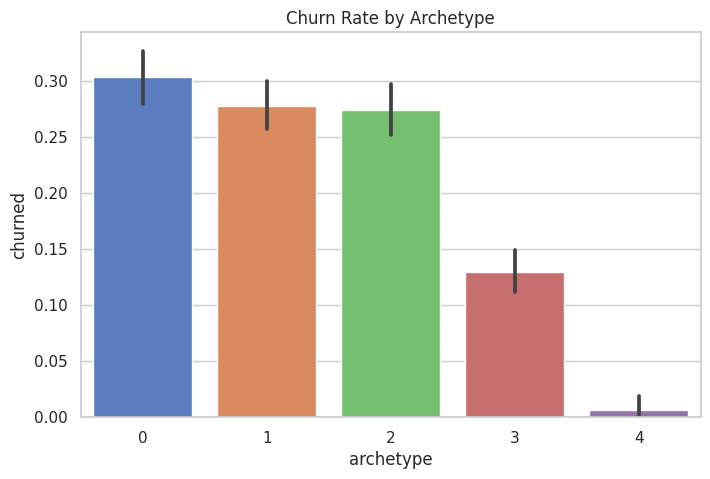

In [51]:
# ==========================================================
# 7️⃣ Archetype Identification – Clustering Players
# ==========================================================
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features_for_cluster = [
    'videos_uploaded_30d', 'pose_score', 'reaction_time', 'alignment_score',
    'hours_volunteered', 'mentor_sessions', 'skill_rating_current',
    'inactive_days', 'mrr_usd'
]

# Drop NAs and scale
df_cluster = df[features_for_cluster].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# Try 4-5 clusters for interpretation
kmeans = KMeans(n_clusters=5, random_state=42)
df['archetype'] = kmeans.fit_predict(X_scaled)

# Analyze cluster characteristics
cluster_summary = df.groupby('archetype')[features_for_cluster + ['churned']].mean().round(2)
print(cluster_summary)

plt.figure(figsize=(8,5))
sns.barplot(x='archetype', y='churned', data=df)
plt.title('Churn Rate by Archetype')
plt.show()
